# LCPB 21-22 exercise 2: *Deep Neural Network (DNN)*

#### TASKS

1. Study the performance of the DNN when the number N of samples is
a) reduced
b) increased
c) augmented
Point 1.c means taking the given N=4000 samples, split them in training and validation, and
“augment” the training samples by generating artificial ones that are similar to the real samples. For
instance, a given sample x=(x1,x2) can be transformed to multiple copies (x1+s1, x2+s2) where
each (s1,s2) is a small random shift.
2. Implement a “grid search” as shown in NB11 to improve one or more of the aspects or
parameters of the model. Possible tests include: different activation units (sigmoid, relu, elu,
etc.), different minimization algorithms (ADAM, RMSprop, Nesterov, etc.), different
dropouts, different size or number of layers, etc.

##### *OPTIONAL*

3. Check if any other rescaling of data or initialization of weights may improve the accuracy of the
DNN.
4. Study different data, for instance generated by the second nonlinear function or other choices.

Raffaele Gaudio, Luca Giorgetti, Emerson Vero, Alessandro Zanoli

NOTE: Due to computational power issue, in this assignment we were forced to use only one NN architecture (model1) and only 200 epochs.

In [18]:
# importing cell
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# DNN stuff
from keras.models import Sequential, clone_model
from keras.layers import Dense, Dropout

%matplotlib notebook

# random seed for reproducibility
np.random.seed(42)

In [2]:
#!mkdir DATA #uncomment to generate the 'DATA directory'

## Data generation


In [3]:
# defining non linear function to interpolate

#f is the labelling function,case c = 2 will only be used in the optional part
def f(x,c=1):
    r=0
    if c==1:
        if x[0]>-20 and x[1]>-40 and x[0]+x[1] < 40:
            r=1
    if c==2:
        if (np.sign(x.sum())*np.sign(x[0]))*np.cos(np.linalg.norm(x)/(2*np.pi))>0:
            r=1
    return r

#needed to save data and labels
def filename(s,TYPE=1):
    return "./DATA/"+s+"-for-DNN-"+str(TYPE)+".dat"


In [4]:
#Now we generate the original dataset

# number of data
N=4000

# size of each sample
L=2

# box size
B=100

TYPE=1


x, y = (np.random.random((N,2))-0.5)*B, np.zeros(N)
for i in range(N):
    # label data according to a nonlinear function "f"
    y[i] = f(x[i],c = 1)       

np.savetxt(filename("data_original",TYPE),x)
np.savetxt(filename("labels_original",TYPE),y,fmt="%d")

<IPython.core.display.Javascript object>


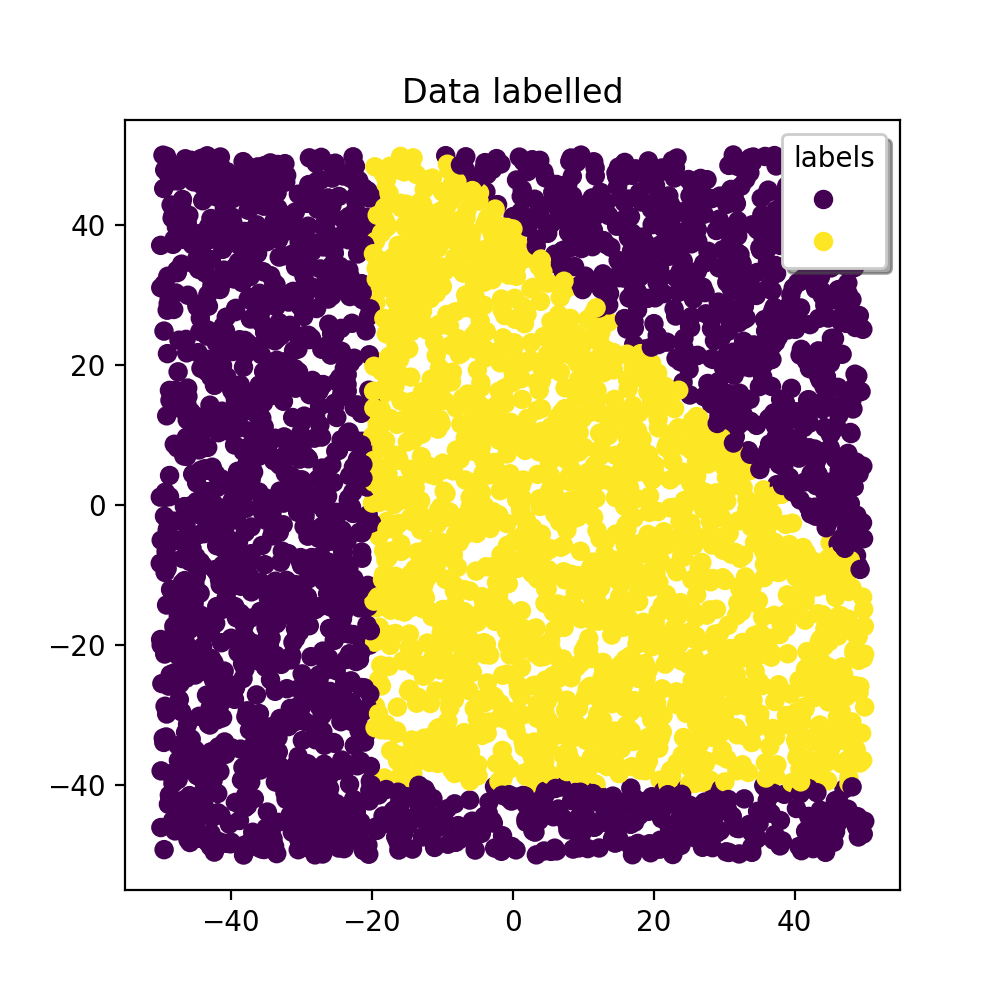

In [35]:
#plotting the original dataset with TYPE = 1
        
fig, ax = plt.subplots(nrows = 1, ncols = 1,figsize = (5,5))
scatter = ax.scatter(x[:,0],x[:,1],c=y)
ax.set_title("Data labelled")
ax.legend(handles=scatter.legend_elements()[0], 
           title="labels", shadow = True)
plt.show();

## Training


In [6]:
#percentage of data used for training
perc_train = 0.8

# Keras works with numpy arrays: just use them from the start
x = np.loadtxt(filename("data_original",TYPE), delimiter=' ')
y = np.loadtxt(filename("labels_original",TYPE), delimiter=' ')

N_train = int(perc_train * N)
print(f'data: {N}\ntrain: {N_train}') #printing the length of the whole dataset and the length of the training set

data: 4000
train: 3200


In [7]:
# Train-Test splitting
(x_train, y_train) = (x[0:N_train],y[0:N_train])
(x_test, y_test) = (x[N_train:],y[N_train:])
print("Train:",len(x_train),"\t test:",len(x_test))

Train: 3200 	 test: 800


In [8]:
# Rescaling data dividing them by their variance, the mean is already zero.
def Rescale(x):
    return x/50

x_train_norm = Rescale(x_train)
x_test_norm = Rescale(x_test)


In [9]:
# Definition of two models of neural network
nepoch = 200 #due to computational limitations

model1 = Sequential()
model1.add(Dense(L,input_shape=(L,),activation='relu'))
model1.add(Dense(20,activation='relu'))
model1.add(Dense(20,activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1,activation='sigmoid'))

#creating clones in order to avoid training the same model with different datasets

model_red=clone_model(model1)
model_in=clone_model(model1)
model_aug=clone_model(model1)



print(model1.summary())

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 6         
                                                                 
 dense_1 (Dense)             (None, 20)                60        
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 507
Trainable params: 507
Non-trainable params: 0
_________________________________________________________________
None


2022-03-19 21:18:53.128442: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-19 21:18:53.128530: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
# compile it with a given loss function and optimizer algorithm
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model_red.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_in.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_aug.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [11]:
# TRAINING

fit1 = model1.fit(x_train_norm, y_train,
               epochs = nepoch, batch_size = 50,
               validation_data=(x_test_norm,y_test),
               verbose=0)

2022-03-19 21:18:53.271437: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-19 21:18:53.440714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 21:18:53.847151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<IPython.core.display.Javascript object>


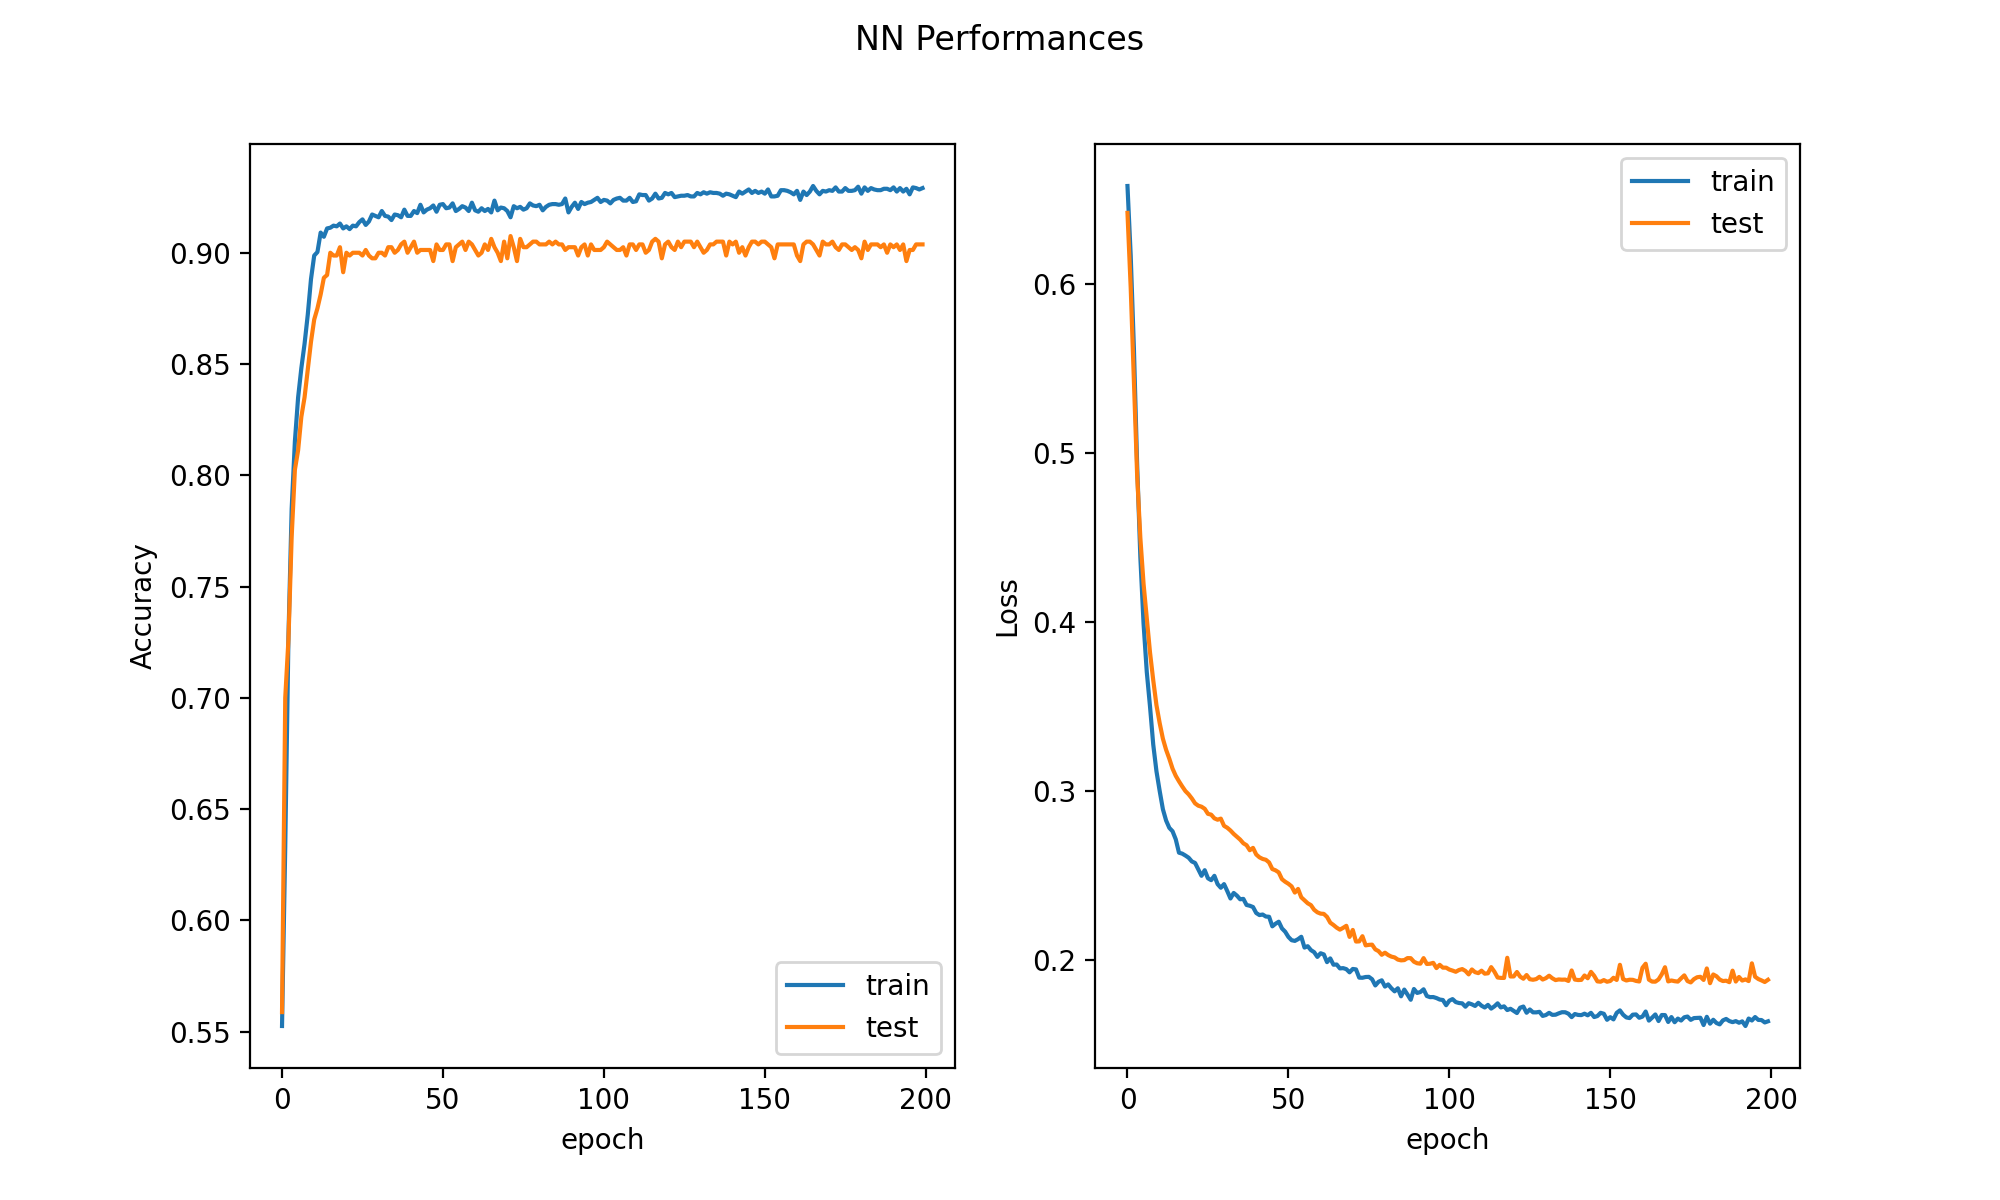

16/16 [==============================] - 0s 3ms/step - loss: 0.1884 - accuracy: 0.9038
Test loss: 0.18843193352222443


In [12]:
#plotting the accuracy and the loss for the first model
fig,axs=plt.subplots(1,2,figsize=(10,6.))
axs[0].plot(fit1.history['accuracy'],label="train")
axs[0].plot(fit1.history['val_accuracy'],label="test")
axs[0].set_xlabel('epoch')
axs[0].set_ylabel("Accuracy")

axs[1].plot(fit1.history['loss'],label="train")
axs[1].plot(fit1.history['val_loss'],label="test")
axs[1].set_xlabel('epoch')
axs[1].set_ylabel("Loss")

plt.suptitle('NN Performances')
for ax in axs: ax.legend()

plt.show();

results=model1.evaluate(x_test_norm,y_test,batch_size=50)
print('Test loss:',results[0])

In [13]:
#let's generate the modified training sets

#reduced dataset
N_red = 3000
(x_train_red, y_train_red) = (x_train[:N_red], y_train[:N_red])
x_train_red = Rescale(x_train_red)

#increased dataset
N_in = 2000
x_train_plus, y_train_plus = (np.random.random((N_in,2))-0.5)*B, np.zeros(N_in)

for i in range(N_in):
    y_train_plus[i] = f(x_train_plus[i],TYPE)
    
x_train_in = np.vstack((x_train,x_train_plus))
y_train_in = np.hstack((y_train,y_train_plus))

x_train_in = Rescale(x_train_in)

#augmented dataset
#data augmentation can be done in different ways, we simply apply a random translation to the whole dataset 
x1_shift = np.random.randn() * 10 #shifts taken from a normal distribution
x2_shift = np.random.randn() * 10

x_train_shift, y_train_shift = np.array([x_train[:,0] + x1_shift, x_train[:,1] + x2_shift]).T, np.zeros(N_train)

for i in range(N_train):
    y_train_shift[i] = f(x_train_shift[i],TYPE)

x_train_aug = np.vstack((x_train,x_train_shift))
y_train_aug = np.hstack((y_train,y_train_shift))

x_train_aug = Rescale(x_train_aug)

<IPython.core.display.Javascript object>


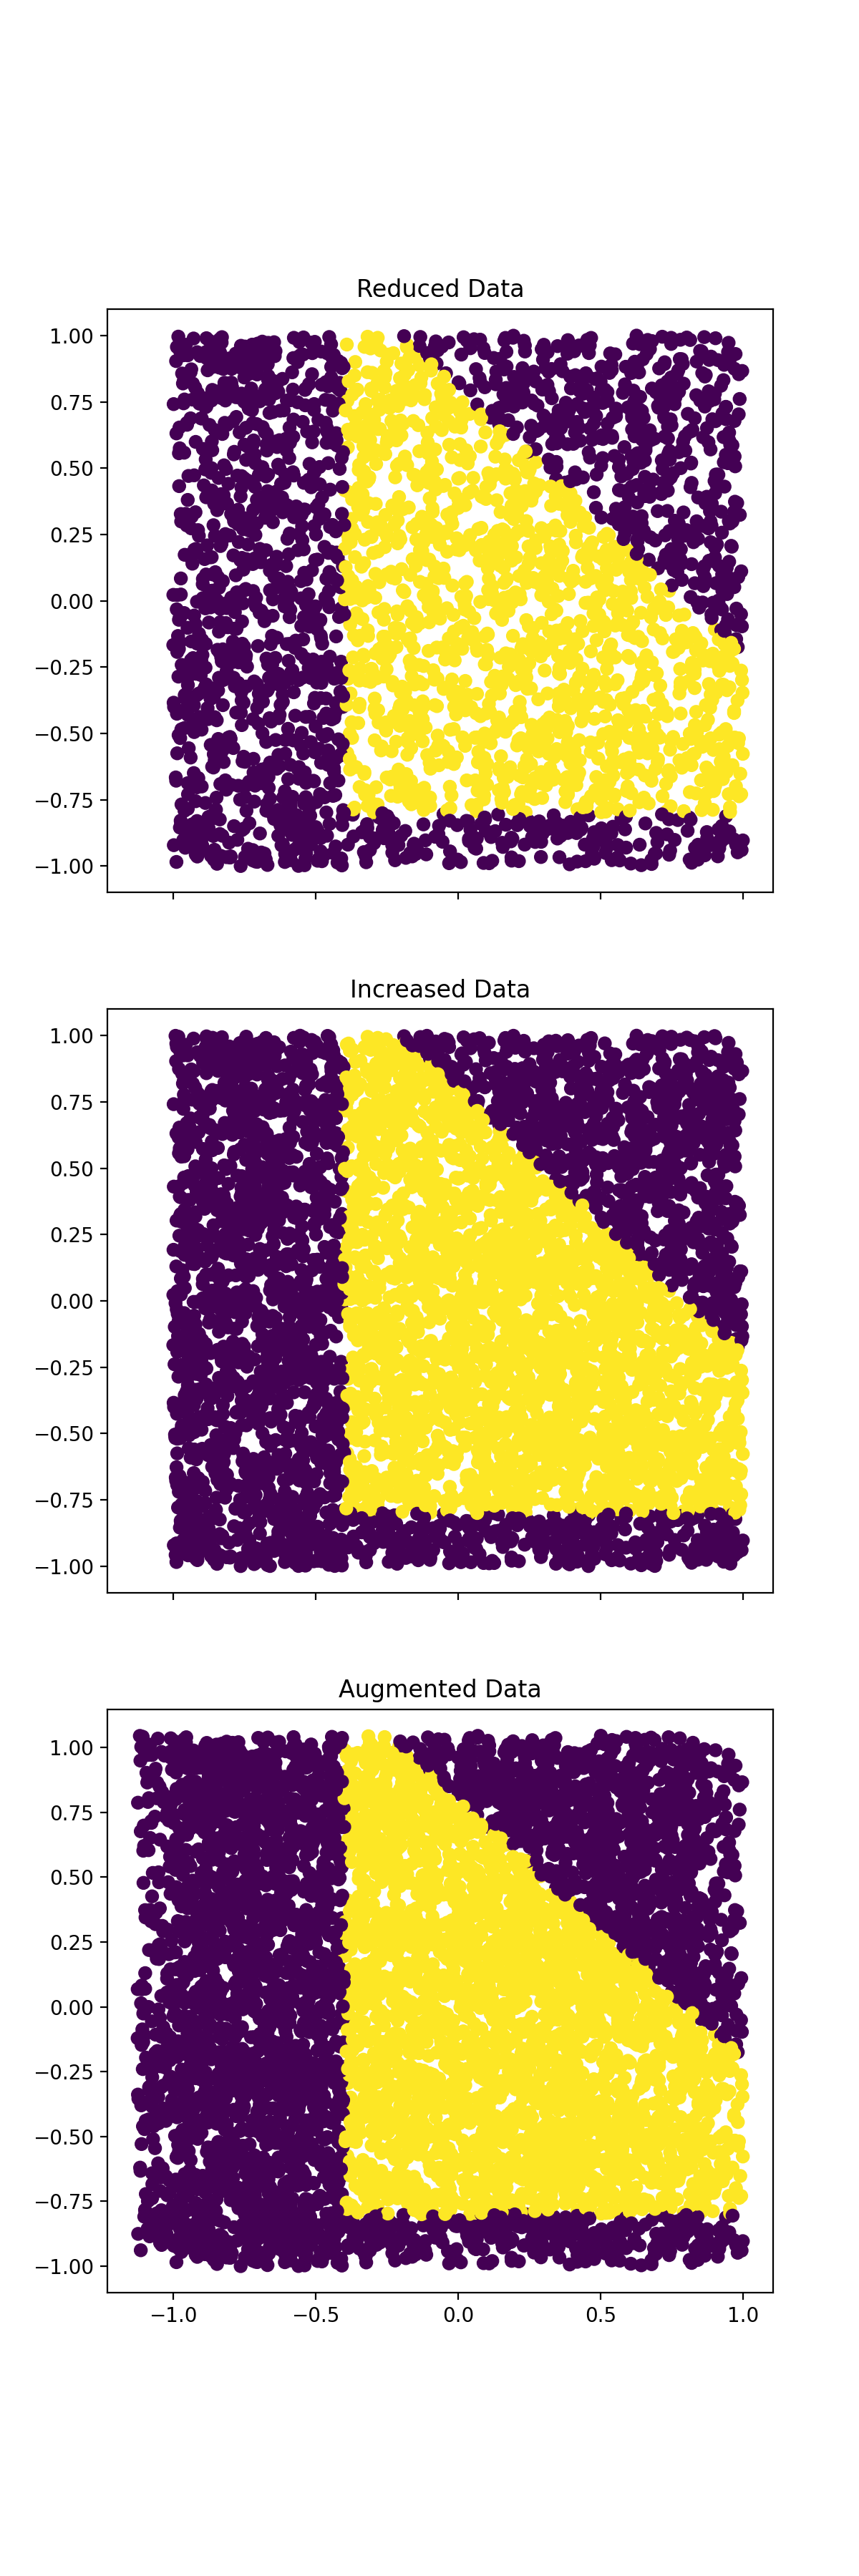

In [14]:
#plotting everything just to see if data have been correctly generated

fig,axs = plt.subplots(nrows=3, ncols = 1, sharex = True, figsize = (6,18))
axs[0].scatter(x_train_red[:,0],x_train_red[:,1], c = y_train_red)
axs[1].scatter(x_train_in[:,0], x_train_in[:,1], c = y_train_in)
axs[2].scatter(x_train_aug[:,0], x_train_aug[:,1], c = y_train_aug)
axs[0].set_title('Reduced Data')
axs[1].set_title('Increased Data')
axs[2].set_title('Augmented Data')
plt.show()


In [15]:
#Now train the two models using the modified dataset, this will need a very long time
fit1_red = model_red.fit(x_train_red, y_train_red,
               epochs = nepoch, batch_size = 50,
               validation_data=(x_test_norm,y_test),
               verbose=0)


fit1_in = model_in.fit(x_train_in, y_train_in,
               epochs = nepoch, batch_size = 50,
               validation_data=(x_test_norm,y_test),
               verbose=0)

fit1_aug = model_aug.fit(x_train_aug, y_train_aug,
               epochs = nepoch, batch_size = 50,
               validation_data=(x_test_norm,y_test),
               verbose=0)


2022-03-19 21:19:41.686723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 21:19:42.015741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 21:20:29.348078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 21:20:29.816537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 21:21:42.055464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 21:21:42.597218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<IPython.core.display.Javascript object>


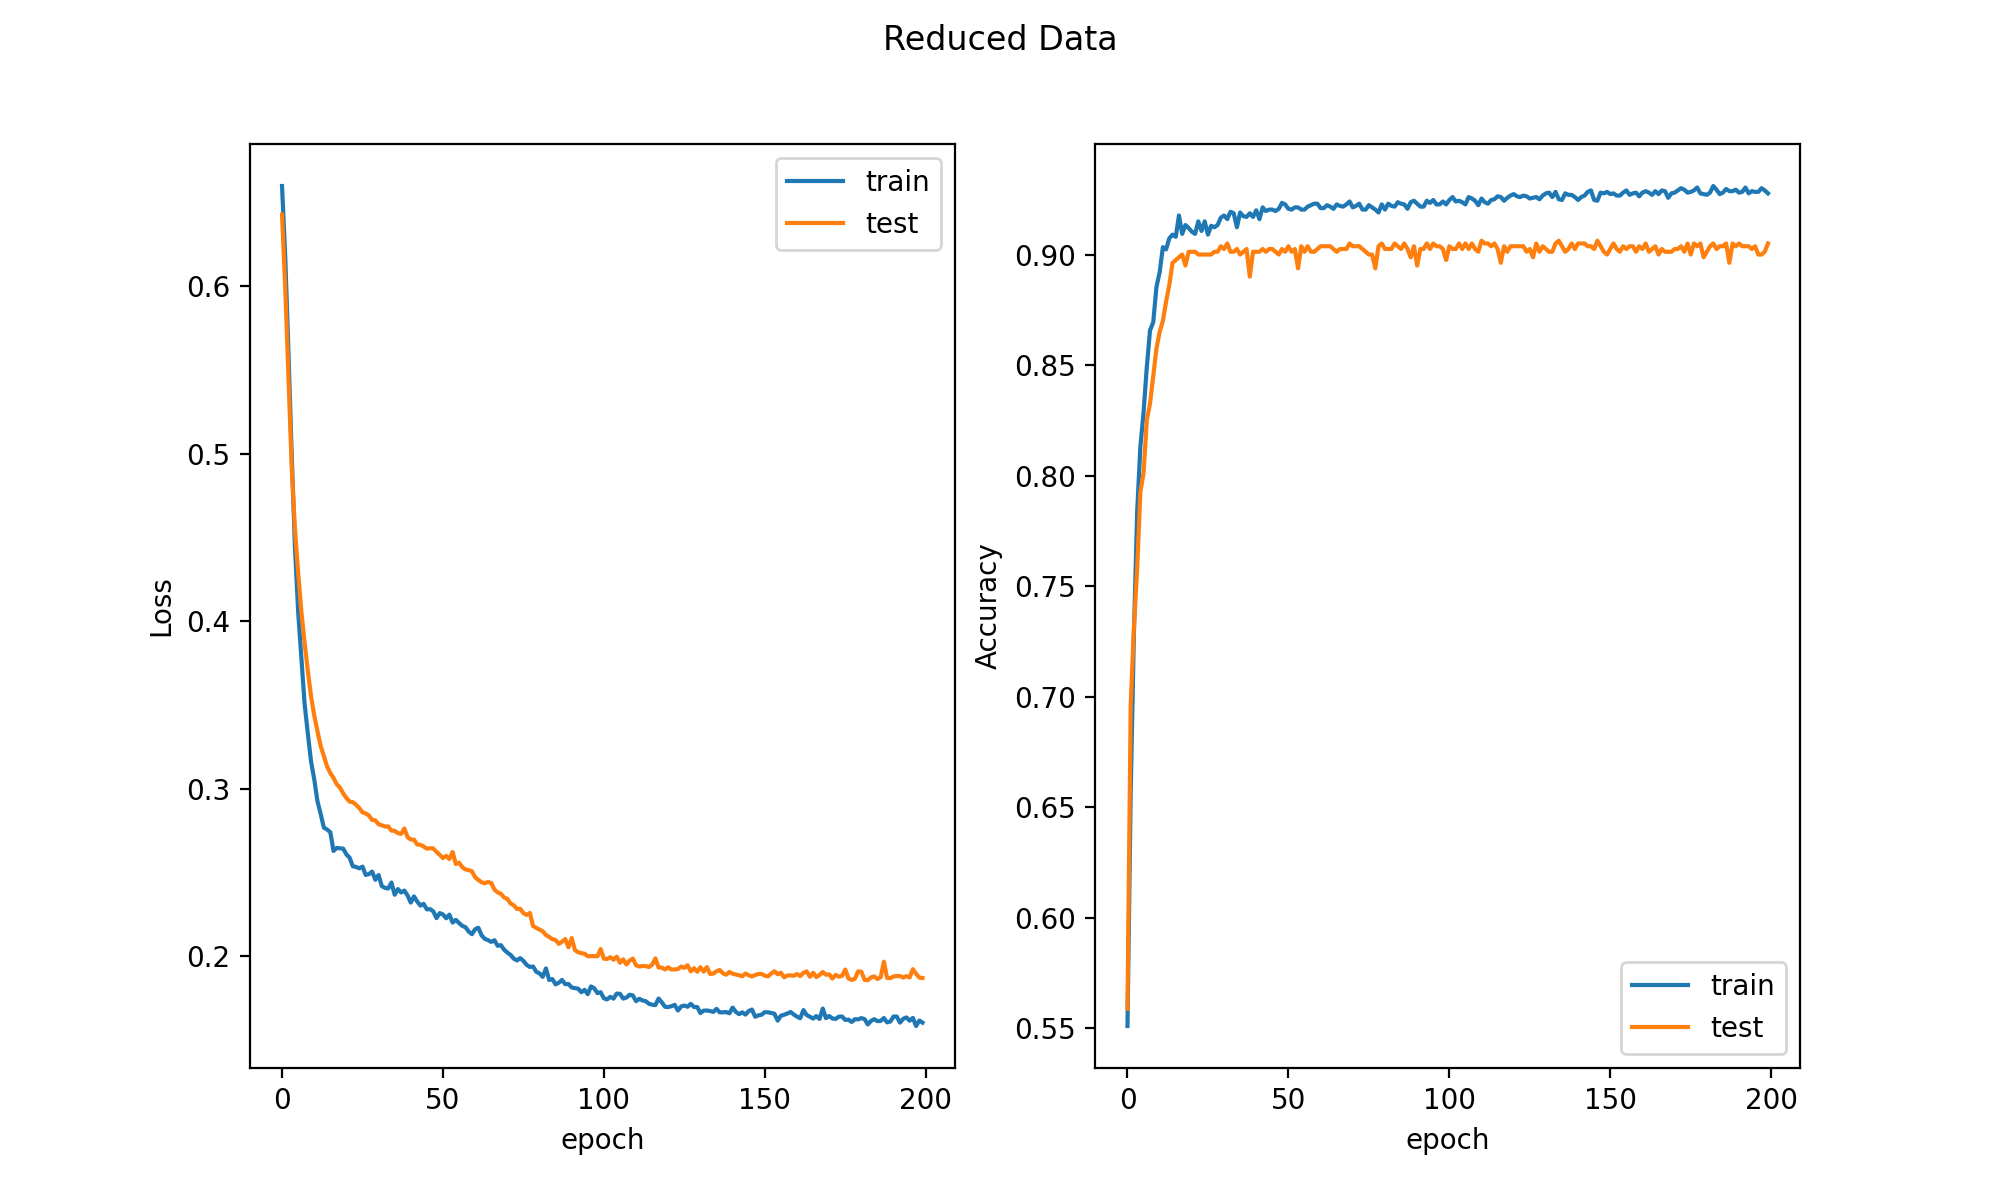

<IPython.core.display.Javascript object>


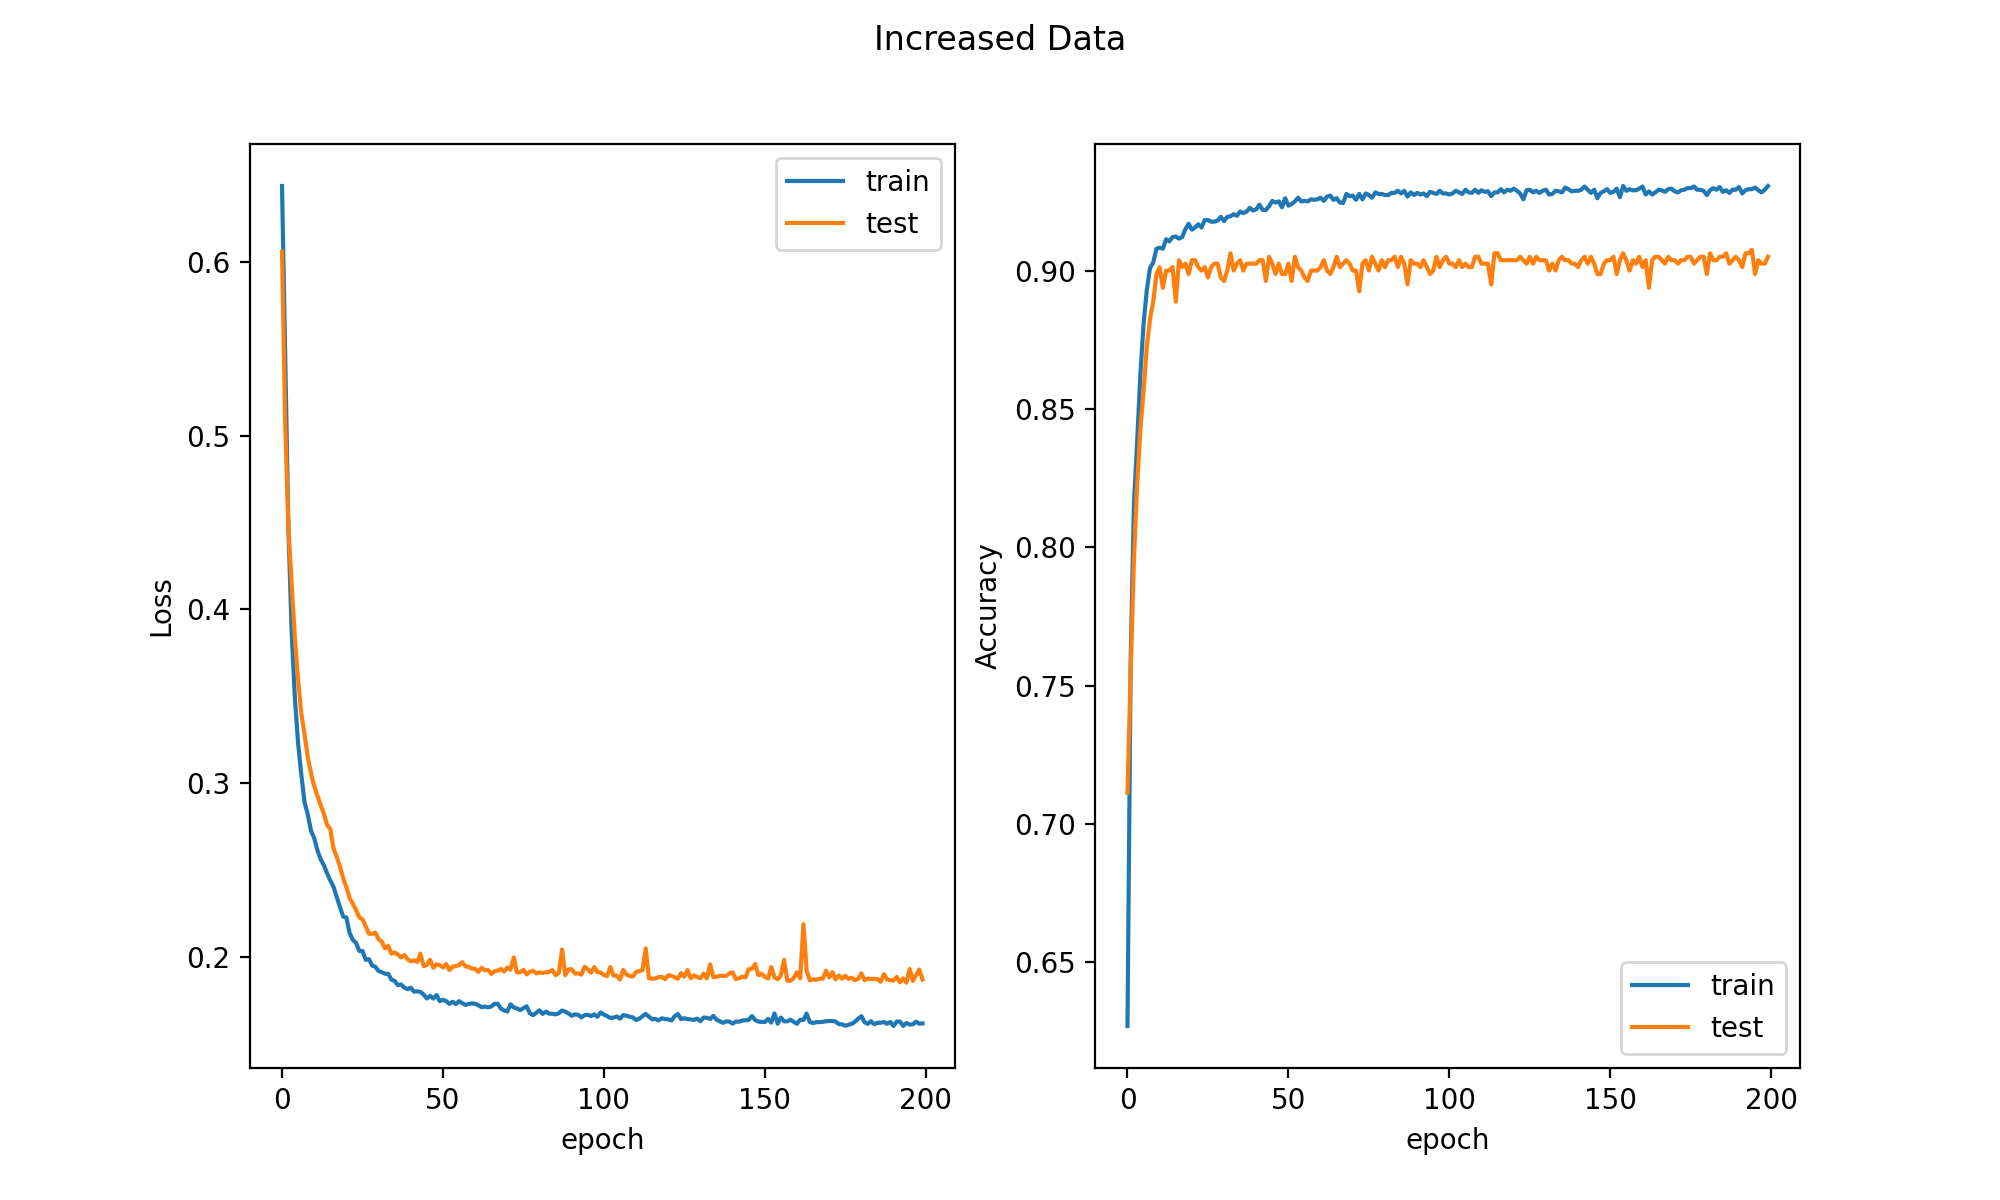

<IPython.core.display.Javascript object>


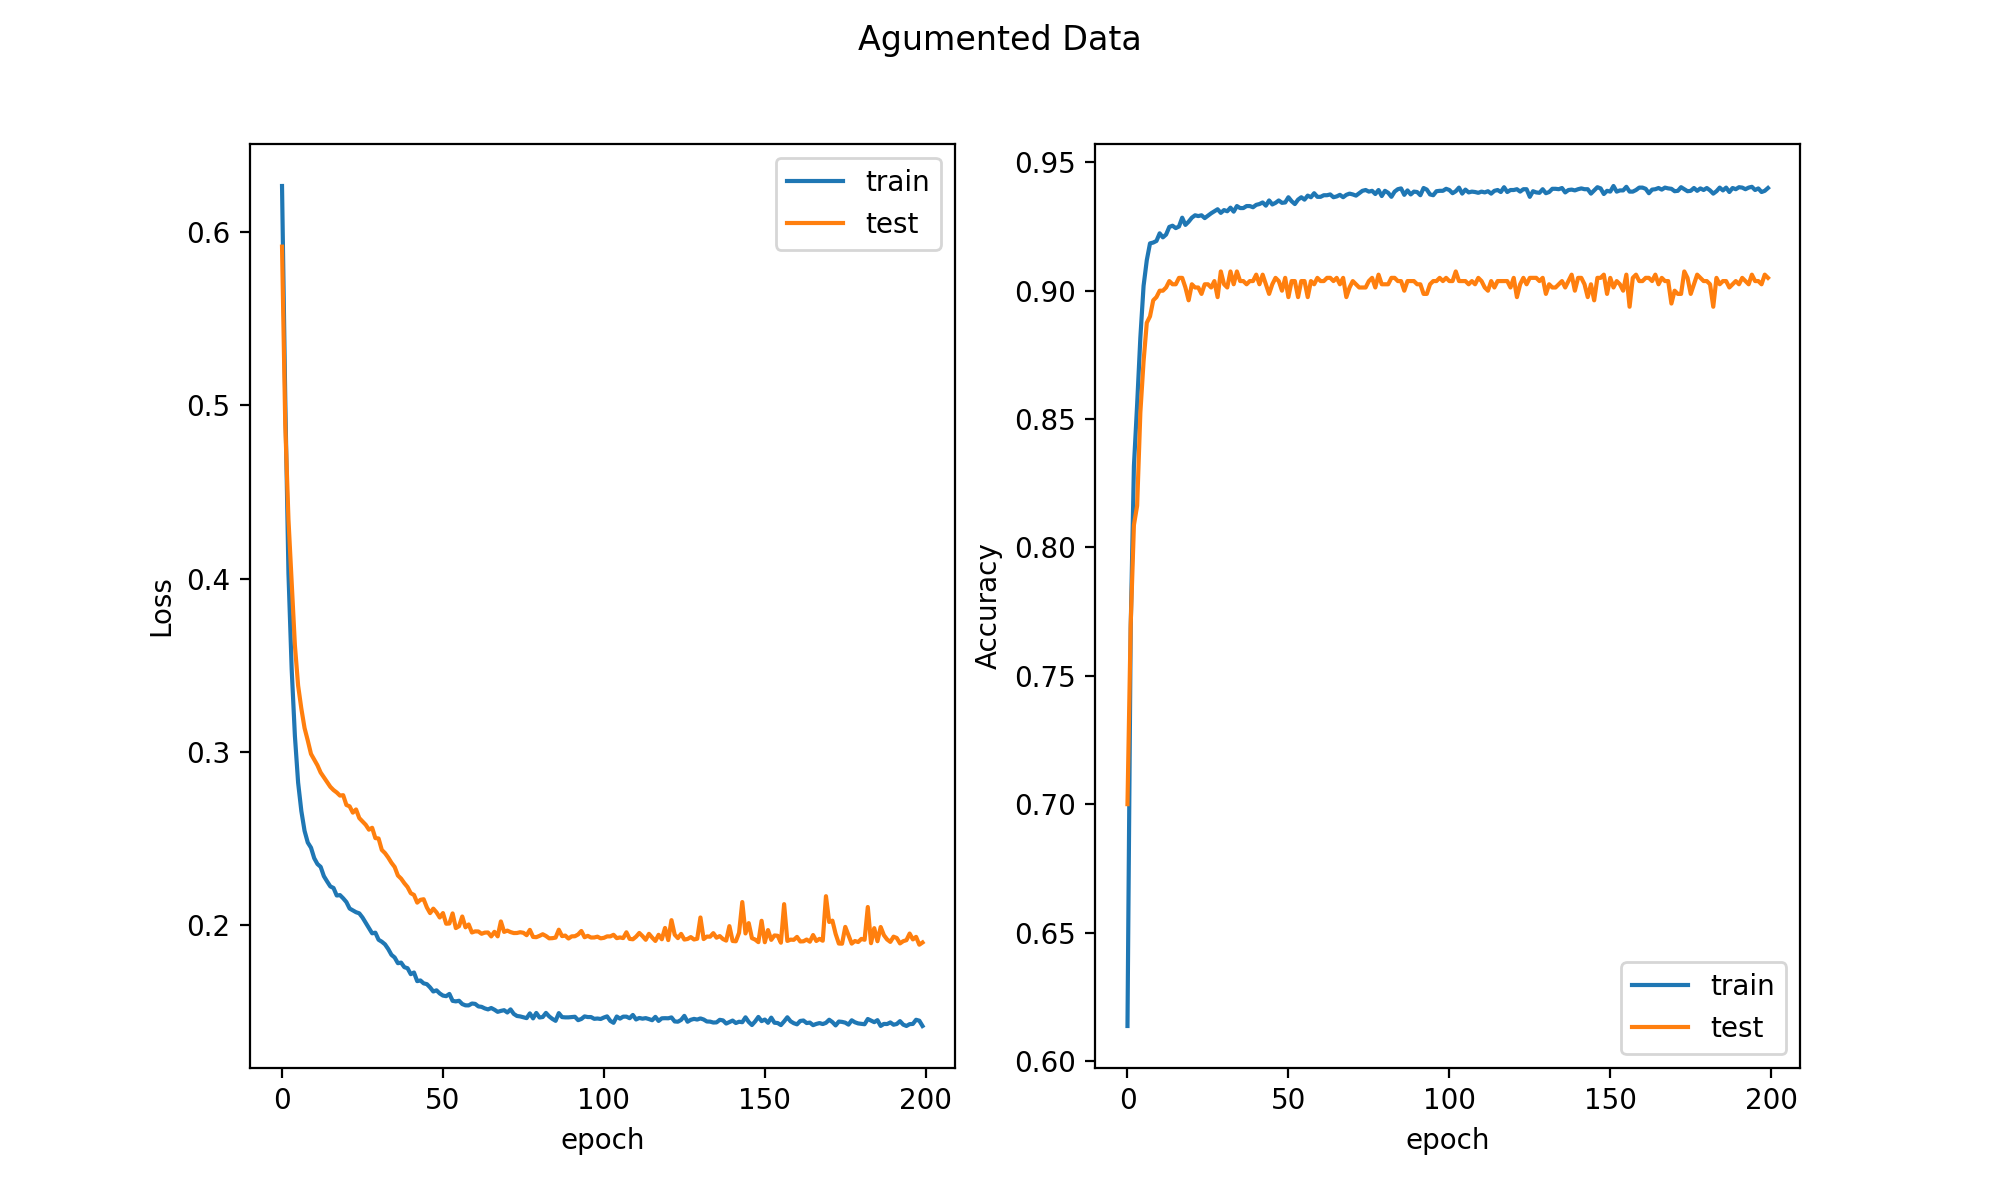

16/16 [==============================] - 0s 3ms/step - loss: 0.1871 - accuracy: 0.9050
Test loss for the reduced set: 0.18843193352222443 

16/16 [==============================] - 0s 3ms/step - loss: 0.1868 - accuracy: 0.9050
Test loss for the increased set: 0.18843193352222443 

16/16 [==============================] - 0s 3ms/step - loss: 0.1902 - accuracy: 0.9050
Test loss for the augmented set: 0.18843193352222443 



In [31]:
#plotting the loss curves
fits = [fit1_red, fit1_in, fit1_aug]
title= ['Reduced Data','Increased Data','Agumented Data']


for f1, title in zip(fits,title):
    fig,axs=plt.subplots(1,2,figsize=(10,6.))
    fig.suptitle(title)
    axs[0].plot(f1.history['loss'],label="train")
    axs[0].plot(f1.history['val_loss'],label="test")
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel("Loss")
    
    axs[1].plot(f1.history['accuracy'],label="train")
    axs[1].plot(f1.history['val_accuracy'],label="test")
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel("Accuracy")
    
    for ax in axs: ax.legend()
    plt.show();

        
results_red =model_red.evaluate(x_test_norm,y_test,batch_size=50)
print('Test loss for the reduced set:',results[0],'\n')

results_in =model_in.evaluate(x_test_norm,y_test,batch_size=50)
print('Test loss for the increased set:',results[0],'\n')

results_aug =model_aug.evaluate(x_test_norm,y_test,batch_size=50)
print('Test loss for the augmented set:',results[0],'\n')

## GridSearch

In [37]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier


def compile_model(optimizer=tf.optimizers.Adam(),activation='relu',dropout_rate=0.2):
    
    model = Sequential()
    model.add(Dense(L,input_shape=(L,),activation=activation))
    model.add(Dense(20,activation=activation))
    model.add(Dense(20,activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
    return model

In [38]:
#optimizer

batch_size = 50

# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn=compile_model, 
                        epochs=200, 
                        batch_size=batch_size, 
                        verbose=False)

# list of allowed optional arguments for the optimizer, see `compile_model()`
optimizer = ['SGD', 'RMSprop', 'Adam']

# define parameter dictionary
param_grid = dict(optimizer=optimizer)
# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(x_train_norm,y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
best_optimizer = grid_result.best_params_['optimizer']

/var/folders/0d/wr4vslms6rx70gkgwp1_dz400000gn/T/ipykernel_64320/2450626415.py:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_gridsearch = KerasClassifier(build_fn=compile_model,


Metal device set to: Apple M1
Metal device set to: Apple M1
Metal device set to: Apple M1
Metal device set to: Apple M1
Metal device set to: Apple M1
Metal device set to: Apple M1
Metal device set to: Apple M1
Metal device set to: Apple M1


2022-03-19 22:11:31.154795: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-19 22:11:31.154957: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-03-19 22:11:31.161670: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-19 22:11:31.162391: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL,

2022-03-19 22:13:51.562612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 22:15:55.241125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 22:15:55.256824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 22:15:55.611997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 22:15:55.665420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 22:15:55.740154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 22:15:56.147481: I tensorflow/core/grappler/optimizers/cust

Best: 0.930000 using {'optimizer': 'RMSprop'}
0.902813 (0.044276) with: {'optimizer': 'SGD'}
0.930000 (0.010289) with: {'optimizer': 'RMSprop'}
0.898438 (0.062788) with: {'optimizer': 'Adam'}


In [39]:
#batchsize


# define the grid search parameters
batch_size = [50, 100, 150]

# define parameter dictionary
param_grid = dict(batch_size=batch_size)
# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(x_train_norm,y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
best_batch_size = grid_result.best_params_['batch_size']

2022-03-19 22:16:38.697063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 22:16:38.698108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 22:16:38.705911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 22:16:38.710101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 22:16:38.730885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 22:16:38.746683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 22:16:38.751477: I tensorflow/core/grappler/optimizers/cust

Best: 0.934375 using {'batch_size': 100}
0.927188 (0.009713) with: {'batch_size': 50}
0.934375 (0.004308) with: {'batch_size': 100}
0.925000 (0.008089) with: {'batch_size': 150}


In [40]:
#activation


# define the grid search parameters
activation = ['relu', 'tanh', 'sigmoid']
# define parameter dictionary
param_grid = dict(activation=activation)

# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(x_train_norm,y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

best_activation = grid_result.best_params_['activation']

2022-03-19 22:19:49.232484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 22:19:50.163201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 22:19:50.176672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 22:19:50.192694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 22:19:50.192965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 22:19:50.235437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 22:19:50.251701: I tensorflow/core/grappler/optimizers/cust

Best: 0.950313 using {'activation': 'tanh'}
0.929688 (0.006629) with: {'activation': 'relu'}
0.950313 (0.016370) with: {'activation': 'tanh'}
0.830000 (0.074722) with: {'activation': 'sigmoid'}


In [41]:
#droprate


# define the grid search parameters
dropout_rate = [0.1, 0.2, 0.3, 0.4]
# define parameter dictionary
param_grid = dict(dropout_rate=dropout_rate)

# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(x_train_norm,y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

best_dropout_rate = grid_result.best_params_['dropout_rate']    

2022-03-19 22:25:14.559256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 22:25:14.570141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 22:25:14.582334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 22:25:14.590323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 22:25:14.592325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 22:25:14.622423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 22:25:14.633099: I tensorflow/core/grappler/optimizers/cust

Best: 0.928750 using {'dropout_rate': 0.2}
0.908125 (0.040594) with: {'dropout_rate': 0.1}
0.928750 (0.009089) with: {'dropout_rate': 0.2}
0.900938 (0.050249) with: {'dropout_rate': 0.3}
0.895938 (0.054617) with: {'dropout_rate': 0.4}


In [42]:
#Let's create a NN with the best parameters

nepoch=200

model_best = Sequential()
model_best.add(Dense(L,input_shape=(L,),activation=best_activation))
model_best.add(Dense(20,activation=best_activation))
model_best.add(Dense(20,activation=best_activation))
model_best.add(Dropout(best_dropout_rate))
model_best.add(Dense(1,activation='sigmoid'))

model_best.compile(loss='binary_crossentropy',
              optimizer=best_optimizer,
              metrics=['accuracy'])

In [43]:
fit_best = model_best.fit(x_train_norm, y_train,
               epochs = nepoch, batch_size = best_batch_size,
               validation_data=(x_test_norm,y_test),
               verbose=0)

2022-03-19 22:31:54.717676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 22:31:55.122712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<IPython.core.display.Javascript object>


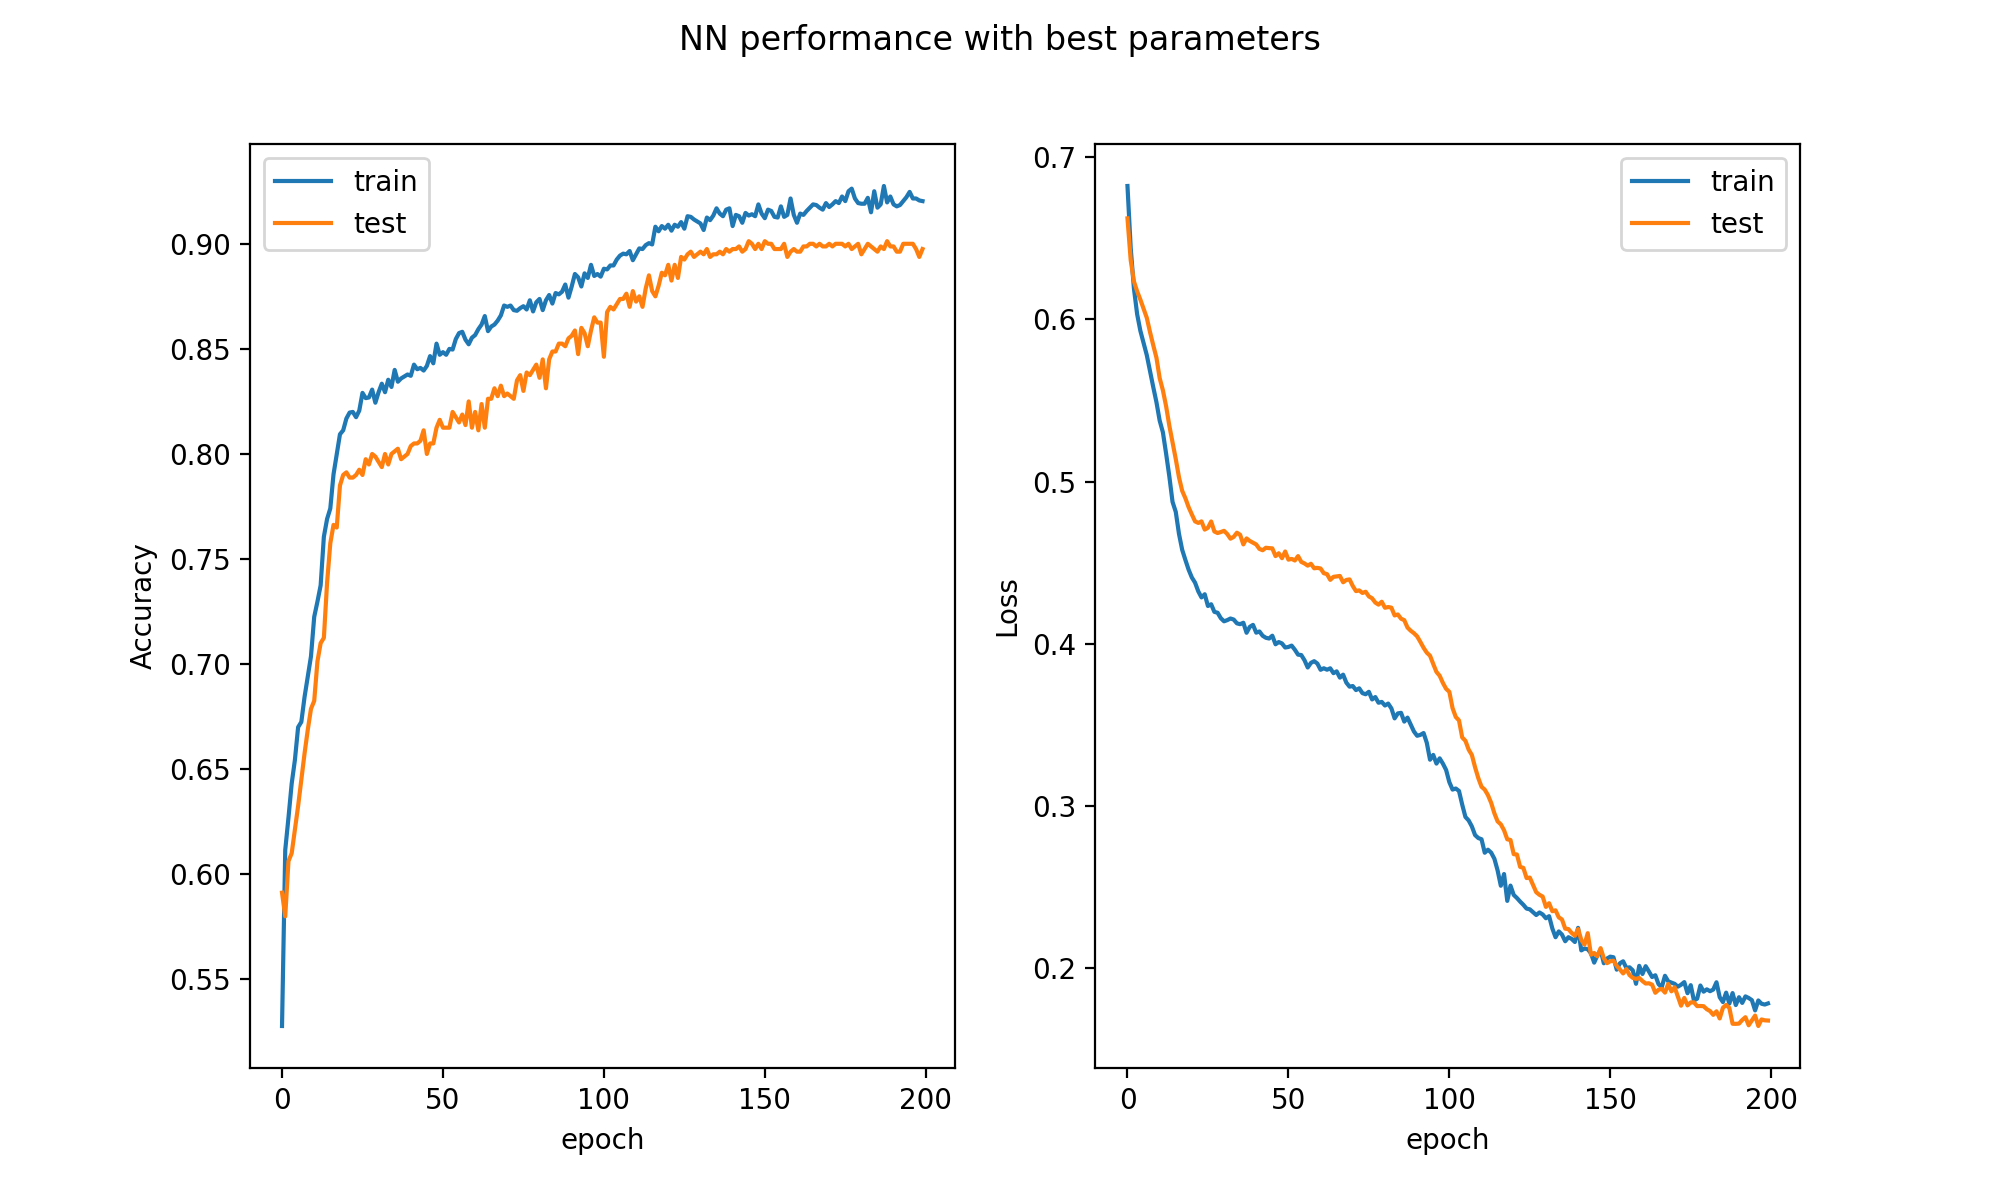

8/8 [==============================] - 0s 4ms/step - loss: 0.1679 - accuracy: 0.8975
Test loss: 0.18843193352222443 



In [45]:
#plotting the accuracy and the loss for the first model
fig,axs=plt.subplots(1,2,figsize=(10,6.))
axs[0].plot(fit_best.history['accuracy'],label="train")
axs[0].plot(fit_best.history['val_accuracy'],label="test")
axs[0].set_xlabel('epoch')
axs[0].set_ylabel("Accuracy")

axs[1].plot(fit_best.history['loss'],label="train")
axs[1].plot(fit_best.history['val_loss'],label="test")
axs[1].set_xlabel('epoch')
axs[1].set_ylabel("Loss")

plt.suptitle('NN performance with best parameters')
for ax in axs: ax.legend()

plt.show();

results_best =model_best.evaluate(x_test_norm,y_test,batch_size=best_batch_size)
print('Test loss:',results[0],'\n')